
# CDMO Project - SAT Modelling
---


In [1]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import time
import random

## 🧰 Utils

In [2]:
def solve_mcp_z3(num_couriers, num_items, load_limits, item_sizes, int_distance_matrix):
    distance_matrix = [[IntVal(int_distance_matrix[p][q]) for q in range(num_items+1)]
                   for p in range(num_items+1)]


    # Initialize the Z3 optimizer
    opt = Optimize()

    # Decision Variables:
    # x[i][j] = 1 if courier i is assigned to item j, 0 otherwise
    x = [[Bool(f'x_{i}_{j}') for j in range(num_items)] for i in range(num_couriers)]

    # y[i][p][q] = 1 if courier i travels from point p to point q, 0 otherwise
    y = [[[Bool(f'y_{i}_{p}_{q}') for q in range(num_items + 1)]
          for p in range(num_items + 1)] for i in range(num_couriers)]

    # d[i] = total distance traveled by courier i
    d = [Int(f'd_{i}') for i in range(num_couriers)]

    # max_distance = the maximum distance traveled by any courier
    max_distance = Int('max_distance')

    # Constraints:

    # Each item must be assigned to exactly one courier
    for j in range(num_items):
        opt.add(Sum([If(x[i][j], 1, 0) for i in range(num_couriers)]) == 1)

    # Each courier's load must not exceed their capacity
    for i in range(num_couriers):
      # Add the load constraint for each courier
      opt.add(Sum([If(x[i][j], item_sizes[j], 0) for j in range(num_items)]) <= load_limits[i])

    # Tour constraints: each courier starts and ends at the origin
    for i in range(num_couriers):
        opt.add(Sum([If(y[i][num_items][q], 1, 0) for q in range(num_items)]) == 1)  # Start at origin
        opt.add(Sum([If(y[i][p][num_items], 1, 0) for p in range(num_items)]) == 1)  # End at origin

    # Ensure each location is visited exactly once by the assigned courier
    for j in range(num_items):
        for i in range(num_couriers):
            opt.add(Sum([If(y[i][p][j], 1, 0) for p in range(num_items + 1)]) == If(x[i][j], 1, 0))
            opt.add(Sum([If(y[i][j][q], 1, 0) for q in range(num_items + 1)]) == If(x[i][j], 1, 0))

    # Calculate total distance for each courier
    for i in range(num_couriers):
      # Create a list to hold distance terms for the current courier
      distance_terms = []

      # Loop over all points (including depot) to sum distances
      for p in range(num_items + 1):  # Including depot
          for q in range(num_items + 1):  # Including depot
              # Use an integer value for distance matrix
              distance = distance_matrix[p][q]  # Make sure this is an integer
              distance_terms.append(If(y[i][p][q], distance, 0))

      # Add the constraint for the total distance for courier i
      opt.add(d[i] == Sum(distance_terms))

    # The maximum distance is at least the distance traveled by any courier
    for i in range(num_couriers):
        opt.add(max_distance >= d[i])

    # Objective: minimize the maximum distance
    opt.minimize(max_distance)

    # Solve the problem
    routes = []
    if opt.check() == sat:
        model = opt.model()
        print(f'Minimum maximum distance: {model[max_distance]}')
        for i in range(num_couriers):
            assigned_items = [j + 1 for j in range(num_items) if model.evaluate(x[i][j])]
            routes.append(assigned_items)
            print(f'Courier {i + 1}: Assigned items: {assigned_items}, Distance: {model[d[i]]}')
    else:
        print("No solution found.")

    return routes


In [3]:
def generate_hex_colors(size):
    hex_colors = []
    for _ in range(size):
        # Generate a random color and format it as a hex string
        hex_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        hex_colors.append(hex_color)
    return hex_colors

def visualize_solution(num_couriers, num_items, routes):
  # Create a graph
  G = nx.Graph()

  # Assign colors to different couriers
  colors = generate_hex_colors(len(routes))

  # Add edges for each courier route
  for i, route in enumerate(routes):
      # Add edges from depot to first customer, between customers, and back to depot
      G.add_edge('Depot', f'Customer {route[0]}', color=colors[i])
      for j in range(len(route) - 1):
          G.add_edge(f'Customer {route[j]}', f'Customer {route[j+1]}', color=colors[i])
      G.add_edge(f'Customer {route[-1]}', 'Depot', color=colors[i])

  # Get positions for nodes (using a spring layout to prevent overlap)
  pos = nx.spring_layout(G, seed=42)  # Set seed for reproducibility

  # Extract edge colors
  edge_colors = [G[u][v]['color'] for u, v in G.edges()]

  # Draw the graph
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10,
          edge_color=edge_colors, width=2)

  # Display the plot
  plt.title('Visualize Solution with NetworkX')
  plt.grid(True)
  plt.show()


In [4]:
# Function to read the .dat file and store first four lines
def read_dat_file(file_path, print_summary = False):
    with open(file_path, 'r') as file:
        # Read the first four lines
        m = int(file.readline().strip())  # First line
        n = int(file.readline().strip())  # Second line
        load_sizes = list(map(int, file.readline().strip().split()))  # Third line
        item_sizes = list(map(int, file.readline().strip().split()))  # Fourth line

        # Read the rest of the data into a list (if needed)
        data = []
        for line in file:
            data.append(list(map(int, line.strip().split())))

    if print_summary:
        print(f"num_couriers: {m}")
        print(f"num_items: {n}")
        print(f"Load sizes: {load_sizes}")
        print(f"Item sizes: {item_sizes}")
        print("Distance matrix:")
        print(data)
        print(f'Distance matrix shape: {data.shape}')

    return m, n, load_sizes, item_sizes, np.array(data)


# 📃Experiments

Example data from project description

In [6]:
# Example data
num_couriers = 3
num_items = 7
load_limits = [15, 10, 7]
item_sizes = [3, 2, 6, 8, 5, 4, 4]
distance_matrix = [
    [0, 3, 3, 6, 5, 6, 6, 2],
    [3, 0, 4, 3, 4, 7, 7, 3],
    [3, 4, 0, 7, 6, 3, 5, 3],
    [6, 3, 7, 0, 3, 6, 6, 4],
    [5, 4, 6, 3, 0, 3, 3, 3],
    [6, 7, 3, 6, 3, 0, 2, 4],
    [6, 7, 5, 6, 3, 2, 0, 4],
    [2, 3, 3, 4, 3, 4, 4, 0]
]

# Solve the MCP problem using Z3
routes = solve_mcp_z3(num_couriers, num_items, load_limits, item_sizes, distance_matrix)
visualize_vrp(num_couriers, num_items,routes)

OSError: exception: access violation reading 0x0000000000000000

In [7]:
print(z3.get_version_string())

4.13.3


In [135]:
file_path = 'inst07.dat'  # Replace with your .dat file path
m, n, load_sizes, item_sizes, distance_matrix = read_dat_file(file_path)


start_time = (time.time())
routes = solve_mcp_z3(m,n, load_sizes, item_sizes, distance_matrix)
print(time.time() - start_time)

distance_matrix[0][0] type: <class 'z3.z3.IntNumRef'>
Minimum maximum distance: 74
Courier 1: Assigned items: [3, 13, 17], Distance: 74
Courier 2: Assigned items: [10, 12], Distance: 60
Courier 3: Assigned items: [2, 7, 8], Distance: 68
Courier 4: Assigned items: [1, 4, 11, 14, 16], Distance: 74
Courier 5: Assigned items: [9], Distance: 60
Courier 6: Assigned items: [5, 6, 15], Distance: 32
56.1712920665741


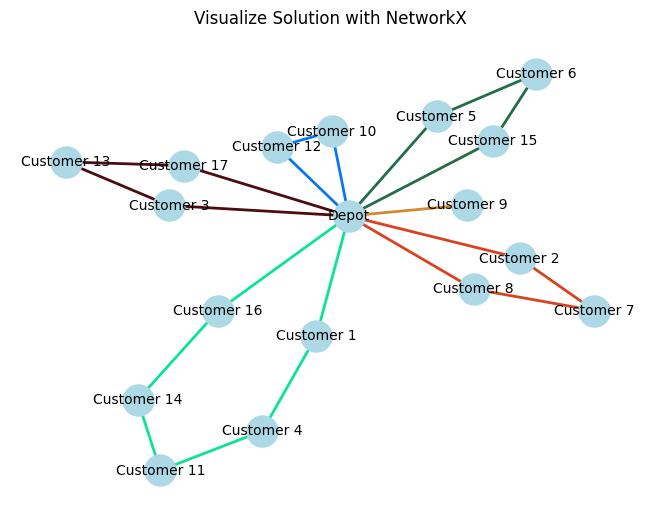

In [136]:
visualize_solution(num_couriers, num_items,routes)